In [3]:
#with help from bharath chandra
from scipy import ndimage #for convolving
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [77]:
img3=imageio.imread('sample3.jpg')
img3=img3.astype('int32')
img3 = np.dot(img3[...,:3], [0.299, 0.587, 0.114])
img4=imageio.imread('sample4.jpg')
img4=img4.astype('int32')
img4 = np.dot(img4[...,:3], [0.299, 0.587, 0.114])

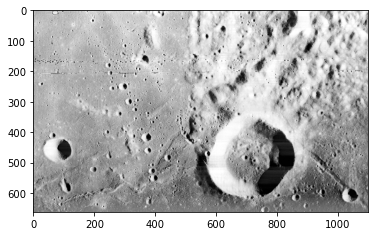

In [25]:
plt.imshow(img4,cmap=plt.get_cmap('gray'))

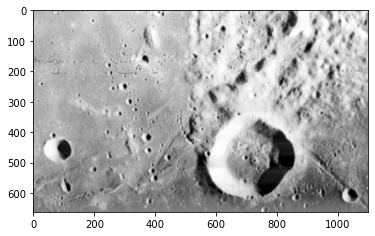

In [26]:
img4_gaussian=ndimage.gaussian_filter(img4,sigma=1.4)
plt.imshow(img4_gaussian,cmap=plt.get_cmap('gray'))

In [42]:
img4_gaussian.shape

(662, 1100)

In [35]:
def sobel_filter(image,directions):
    if(directions=='x'):
        opx=[[-1,0,+1],[-2,0,+2],[-1,0,+1]]
        Gx=np.array(opx)
        operated_image=ndimage.convolve(image,Gx)
    if(directions=='y'):
        opy=[[-1,-2,-1],[0,0,0],[+1,+2,+1]]
        Gy=np.array(opy)
        operated_image=ndimage.convolve(image,Gy)
    
    return operated_image

In [36]:
def normalize(image): #max normalization
    return image/np.max(image)

In [38]:
gx=sobel_filter(img4_gaussian,'x')
gx=normalize(gx)

In [41]:
gy=sobel_filter(img4_gaussian,'y')
gy=normalize(gy)

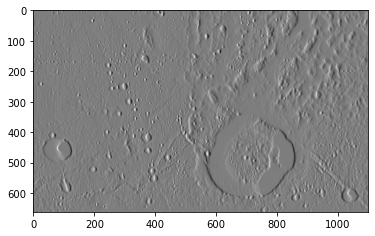

In [43]:
plt.imshow(gx,cmap='gray')

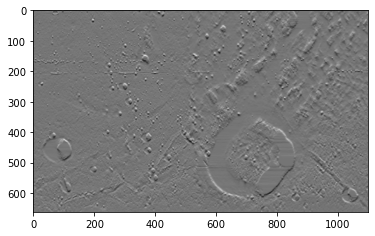

In [44]:
plt.imshow(gy,cmap='gray')

In [45]:
magnitude=np.hypot(gx,gy)

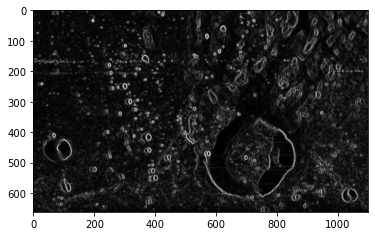

In [46]:
plt.imshow(magnitude,cmap='gray')

In [47]:
gradient_matrix=np.degrees(np.arctan2(gy,gx))
gradient_matrix

array([[ 162.12824123,  154.39733796,   82.15901269, ...,   -0.62324776,
          -5.67985577,  -24.16114478],
       [ 116.17996042,  114.89455848,   86.13472405, ...,    0.71575771,
         -13.70101444,  -51.49206949],
       [  75.27545672,   94.19317179,  103.23366024, ...,    7.48032637,
          -9.72005694,  -54.2989949 ],
       ...,
       [ -84.52810719,  -84.09762511, -136.88932826, ...,  177.93129559,
        -178.33724223, -170.13793262],
       [ -74.73669181,  -58.05304989,  -79.36535785, ...,  174.28749249,
         177.11751378,  178.73313846],
       [ -47.61832771,  -24.20828285,  -29.02297424, ...,  176.87456678,
         178.10504306,  178.0048829 ]])

# Non Maximum Supression

In [49]:
def NMS(Gmag, Grad):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= -22.5 and Grad[i,j] <= 22.5) or (Grad[i,j] <= -157.5 and Grad[i,j] >= 157.5)):
                if((Gmag[i,j] > Gmag[i,j+1]) and (Gmag[i,j] > Gmag[i,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 22.5 and Grad[i,j] <= 67.5) or (Grad[i,j] <= -112.5 and Grad[i,j] >= -157.5)):
                if((Gmag[i,j] > Gmag[i+1,j+1]) and (Gmag[i,j] > Gmag[i-1,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 67.5 and Grad[i,j] <= 112.5) or (Grad[i,j] <= -67.5 and Grad[i,j] >= -112.5)):
                if((Gmag[i,j] > Gmag[i+1,j]) and (Gmag[i,j] > Gmag[i-1,j])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 112.5 and Grad[i,j] <= 157.5) or (Grad[i,j] <= -22.5 and Grad[i,j] >= -67.5)):
                if((Gmag[i,j] > Gmag[i+1,j-1]) and (Gmag[i,j] > Gmag[i-1,j+1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0

    return NMS

In [50]:
image_nms=NMS(magnitude,gradient_matrix)
image_nms=normalize(image_nms)

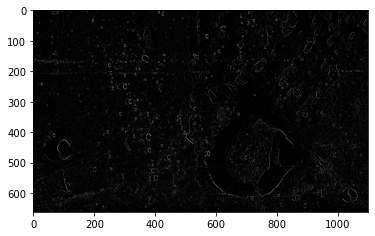

In [51]:
plt.imshow(image_nms,cmap='gray')

In [52]:
def double_thresholding(img):
    highThresholdRatio =0.32
    lowThresholdRatio = 0.30
    GSup = np.copy(img)
    h = int(GSup.shape[0])#height
    w = int(GSup.shape[1])#width
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    for i in range(1,h-1):
        for j in range(1,w-1):
            if(GSup[i,j] > highThreshold):
                GSup[i,j] = 1
            elif(GSup[i,j] < lowThreshold):
                GSup[i,j] = 0
            else:
                if((GSup[i-1,j-1] > highThreshold) or 
                    (GSup[i-1,j] > highThreshold) or
                    (GSup[i-1,j+1] > highThreshold) or
                    (GSup[i,j-1] > highThreshold) or
                    (GSup[i,j+1] > highThreshold) or
                    (GSup[i+1,j-1] > highThreshold) or
                    (GSup[i+1,j] > highThreshold) or
                    (GSup[i+1,j+1] > highThreshold)):
                    GSup[i,j] = 1
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the weak edges which are not connected to strong edges    
    return GSup

In [53]:
thresholded_image=double_thresholding(image_nms)

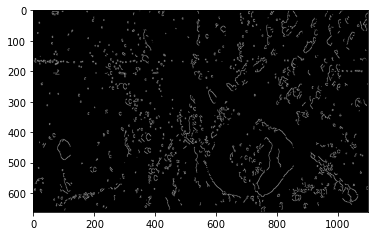

In [54]:
plt.imshow(thresholded_image,cmap='gray')

In [67]:
img3_gaussian=ndimage.gaussian_filter(img3,sigma=1.4)
gx3=sobel_filter(img3_gaussian,'x')
gx3=normalize(gx3)
gy3=sobel_filter(img3_gaussian,'x')
gy3=normalize(gy3)
magnitude3=np.hypot(gx3,gy3)
gradient_matrix3=np.degrees(np.arctan2(gy3,gx3))
image_nms3=NMS(magnitude3,gradient_matrix3)
image_nms3=normalize(image_nms3)
thresholded_image3=double_thresholding(image_nms3)

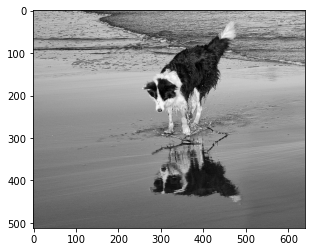

In [76]:
plt.imshow(img3,cmap='gray')

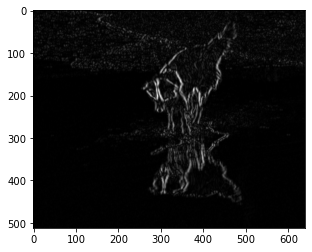

In [73]:
plt.imshow(magnitude3,cmap='gray')

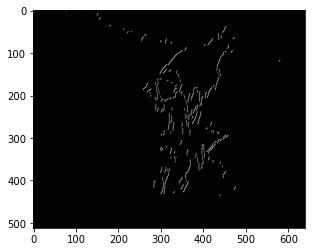

In [74]:
plt.imshow(thresholded_image3,cmap='gray')